In [40]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
from time import time

# FUNÇÃO DE TRANSFERÊNCIA DO CONTROLADOR

In [41]:
s = sp.symbols('s')
K, a, b = (0.5455015616258723, -81.32374082380792, -81.06058001048476)

C = K * (s - a) * (s - b) / s
C

(0.545501561625872*s + 44.3622276166449)*(s + 81.0605800104848)/s

- O controlador é passado para o domínio discreto $z$ quando $s \to \frac{2}{T} \cdot \frac{z-1}{z+1}$

In [42]:
T = 0.5
z = sp.symbols('z')

transZ = 2/T*(z-1)/(z+1)
C = C.subs(s, transZ).expand().simplify()
C

(989.769882135762*z**4 + 1793.64993808818*z**3 - 177.161801197327*z**2 - 1793.64993808818*z - 812.608080938436)/(1.0*z**4 - 2.0*z**2 + 1.0)

- Substituindo $C(s) = \frac{Y(s)}{X(s)}$ (saída sobre a entrada)

In [43]:
X, Y = sp.symbols('X Y')
sp.Eq(Y/X, C)

Eq(Y/X, (989.769882135762*z**4 + 1793.64993808818*z**3 - 177.161801197327*z**2 - 1793.64993808818*z - 812.608080938436)/(1.0*z**4 - 2.0*z**2 + 1.0))

- O próximo passo é dividir tudo pelo termos de maior grau do denominador, ou seja, por $z^4$, e vamos também expandir pra manipular melhor

In [44]:
num, den = sp.fraction(C)
grau = 4

eq = sp.Eq((num*X/z**grau).expand() - (den*Y/z**grau).expand(), 0)
eq

Eq(989.769882135762*X + 1793.64993808818*X/z - 177.161801197327*X/z**2 - 1793.64993808818*X/z**3 - 812.608080938436*X/z**4 - 1.0*Y + 2.0*Y/z**2 - 1.0*Y/z**4, 0)

- Agora dentro deste for serão feitas substituições do tipo $2Y\,z^{-2} = 2Y_{n-2}$

In [45]:
for i in range(10, 0, -1):
    eq = eq.subs(X/z**i, sp.symbols('X_{n-' + str(i) + '}'))
    eq = eq.subs(Y/z**i, sp.symbols('Y_{n-' + str(i) + '}'))

eq

Eq(989.769882135762*X + 1793.64993808818*X_{n-1} - 177.161801197327*X_{n-2} - 1793.64993808818*X_{n-3} - 812.608080938436*X_{n-4} - 1.0*Y + 2.0*Y_{n-2} - 1.0*Y_{n-4}, 0)

- Agora é só isolar o $Y = Y_n$

In [46]:
sol = sp.Eq(Y, sp.solve(eq, Y)[0])
sol

Eq(Y, 989.769882135762*X + 1793.64993808818*X_{n-1} - 177.161801197327*X_{n-2} - 1793.64993808818*X_{n-3} - 812.608080938436*X_{n-4} + 2.0*Y_{n-2} - Y_{n-4})

In [47]:
Y_n = sol.rhs
Y_n = Y_n.subs(sp.symbols('X'), sp.symbols('X_n'))

Y_str = str(Y_n)
Y_str = Y_str.replace('X_{n-1}', 'X_n1').replace('X_{n-2}', 'X_n2').replace('X_{n-3}', 'X_n3').replace('X_{n-4}', 'X_n4')\
             .replace('Y_{n-1}', 'Y_n1').replace('Y_{n-2}', 'Y_n2').replace('Y_{n-3}', 'Y_n3').replace('Y_{n-4}', 'Y_n4') + ';'

print(Y_str)

989.769882135762*X_n + 1793.64993808818*X_n1 - 177.161801197327*X_n2 - 1793.64993808818*X_n3 - 812.608080938436*X_n4 + 2.0*Y_n2 - Y_n4;


# VERIFICANDO

In [48]:
Y_n1 = Y_n2 = Y_n3 = Y_n4 = 0
X_n1 = X_n2 = X_n3 = X_n4 = 0

def computeController(inputValue, setpoint):
    global Y_n1, Y_n2, Y_n3, Y_n4
    global X_n1, X_n2, X_n3, X_n4
    
    X_n = setpoint - inputValue
    Y_n = 989.769882135762*X_n + 1793.64993808818*X_n1 - 177.161801197327*X_n2 - 1793.64993808818*X_n3 - 812.608080938436*X_n4 + 2.0*Y_n2 - Y_n4

    X_n4 = X_n3
    X_n3 = X_n2
    X_n2 = X_n1
    X_n1 = X_n 

    Y_n4 = Y_n3
    Y_n3 = Y_n2
    Y_n2 = Y_n1
    Y_n1 = Y_n
    return Y_n

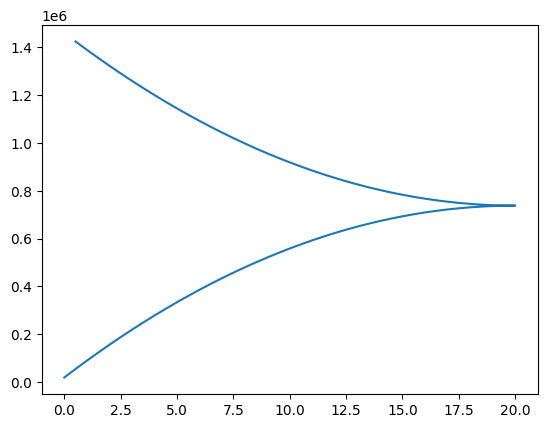

In [49]:
setpoint = 20

inputData  = [val for val in np.arange(0, setpoint, 0.5)] + [val for val in np.arange(setpoint, 0, -0.5)]
outputData = [computeController(val, setpoint) for val in inputData]

plt.plot(inputData, outputData)

In [51]:
print('#define MIN_OUT', min(outputData)) 
print('#define MAX_OUT', max(outputData))

#define MIN_OUT 19795.39764271524
#define MAX_OUT 1422565.3028866444
